In [25]:
import pandas as pd
from pathlib import Path

In [26]:
# Leer archivo sin cabeceras
path = Path('Dataset.csv')
raw = pd.read_csv(path, sep=';', header=None, dtype=str, keep_default_na=False)
raw.head()

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,,,,,,,,,,REGISTRO DE INGRESOS,...,,,,,,,,,,
1,Codigo\nCliente,Ciudad,Zona,Nombre Comercial o \nNombre del Cliente,CodigoVendedor,Vendedor,ene-22,feb-22,mar-22,abr-22,...,feb-25,mar-25,abr-25,may-25,jun-25,jul-25,ago-25,sep-25,Total 2025,Total General
2,1303,La Paz,12 DE OCTUBRE,FERRETERIA ILUTEC,15,ROLY CHALCO,35.14,59.27,83.7,41.1,...,98.23,71.16,27.95,91.91,42.78,48.65,53.46,72.24,538.0,2383.27
3,1291,La Paz,12 DE OCTUBRE,MUNDO LED,15,ROLY CHALCO,0.0,30.47,0.0,30.42,...,38.1,36.59,28.46,32.66,0.0,15.84,42.76,19.56,239.9,1331.31
4,735,La Paz,12 DE OCTUBRE,FERRETERIA TRUJILLO 12 DE OCTUBRE,15,ROLY CHALCO,0.0,295.89,644.91,425.31,...,405.34,209.44,534.83,244.07,245.51,317.13,350.63,362.16,3179.99,17267.69


In [27]:
# Detectar fila de encabezado real
header_row = None
for i, row in raw.iterrows():
    if any('Codigo' in str(x) for x in row):
        header_row = i
        break

if header_row is None:
    raise ValueError("No se encontró una fila con 'Codigo'.")

header_row

1

In [28]:
# Construir DataFrame limpio
new_cols = raw.iloc[header_row].astype(str).str.replace('\n', ' ', regex=True).str.strip().tolist()
data = raw.iloc[header_row+1:].reset_index(drop=True).copy()
data.columns = new_cols

# 4) Limpiar columnas vacías
data = data.loc[:, data.columns.str.strip().astype(bool)]
data = data.dropna(axis=1, how='all')

# 5) Normalizar strings
data = data.map(lambda x: x.strip() if isinstance(x, str) else x)
data = data.replace({'': pd.NA, 'NA': pd.NA, 'nan': pd.NA})

data.head()

,Codigo Cliente,Ciudad,Zona,Nombre Comercial o Nombre del Cliente,CodigoVendedor,Vendedor,ene-22,feb-22,mar-22,abr-22,...,feb-25,mar-25,abr-25,may-25,jun-25,jul-25,ago-25,sep-25,Total 2025,Total General
0,1303,La Paz,12 DE OCTUBRE,FERRETERIA ILUTEC,15,ROLY CHALCO,35.14,59.27,83.7,41.1,...,98.23,71.16,27.95,91.91,42.78,48.65,53.46,72.24,538.0,2383.27
1,1291,La Paz,12 DE OCTUBRE,MUNDO LED,15,ROLY CHALCO,0.0,30.47,0.0,30.42,...,38.1,36.59,28.46,32.66,0.0,15.84,42.76,19.56,239.9,1331.31
2,735,La Paz,12 DE OCTUBRE,FERRETERIA TRUJILLO 12 DE OCTUBRE,15,ROLY CHALCO,0.0,295.89,644.91,425.31,...,405.34,209.44,534.83,244.07,245.51,317.13,350.63,362.16,3179.99,17267.69
3,2446,La Paz,12 DE OCTUBRE,FERRETERIA INNOVA ELECTRIC,15,ROLY CHALCO,187.89,138.22,151.1,104.83,...,177.1,96.73,151.13,218.43,103.03,81.43,290.45,231.95,1535.65,8149.93
4,590,La Paz,12 DE OCTUBRE,FERRETERIA ELECTRICA CANAVIRI,15,ROLY CHALCO,131.11,0.0,108.65,0.0,...,186.58,145.12,227.61,158.34,90.77,0.0,197.52,225.02,1377.3,6793.39


In [29]:
# Convertir columnas numéricas
num_tags = ['-22','-23','-24','-25','Total','total','TOTAL']
num_candidates = [c for c in data.columns if any(t in c for t in num_tags)]

for c in num_candidates:
    data[c] = pd.to_numeric(
        data[c].astype(str).str.replace(r'\s+', '', regex=True).replace({pd.NA: None}),
        errors='coerce'
    )

data[num_candidates].head()

,ene-22,feb-22,mar-22,abr-22,may-22,jun-22,jul-22,ago-22,sep-22,oct-22,...,feb-25,mar-25,abr-25,may-25,jun-25,jul-25,ago-25,sep-25,Total 2025,Total General
0,35.14,59.27,83.70,41.10,74.39,0.00,30.29,58.45,65.29,37.52,...,98.23,71.16,27.95,91.91,42.78,48.65,53.46,72.24,538.00,2383.27
1,0.00,30.47,0.00,30.42,21.76,18.63,44.22,39.57,22.17,28.74,...,38.10,36.59,28.46,32.66,0.00,15.84,42.76,19.56,239.90,1331.31
2,0.00,295.89,644.91,425.31,554.82,220.71,354.72,496.56,304.49,242.49,...,405.34,209.44,534.83,244.07,245.51,317.13,350.63,362.16,3179.99,17267.69
3,187.89,138.22,151.10,104.83,199.72,63.30,72.92,87.27,241.60,169.90,...,177.10,96.73,151.13,218.43,103.03,81.43,290.45,231.95,1535.65,8149.93
4,131.11,0.00,108.65,0.00,0.00,139.53,66.45,0.00,115.06,152.85,...,186.58,145.12,227.61,158.34,90.77,0.00,197.52,225.02,1377.30,6793.39


In [30]:
# Mostrar columnas con sus tipos de datos en una tabla ordenada
dtype_df = pd.DataFrame({
    'columna': data.columns,
    'tipo_de_dato': data.dtypes.astype(str)
})

dtype_df

,columna,tipo_de_dato
Codigo Cliente,Codigo Cliente,object
Ciudad,Ciudad,object
Zona,Zona,object
Nombre Comercial o Nombre del Cliente,Nombre Comercial o Nombre del Cliente,object
CodigoVendedor,CodigoVendedor,object
Vendedor,Vendedor,object
ene-22,ene-22,float64
feb-22,feb-22,float64
mar-22,mar-22,float64
abr-22,abr-22,float64


In [31]:
import re

# Seleccionar columnas con formato mes-año
pattern = r'^(ene|feb|mar|abr|may|jun|jul|ago|sep|oct|nov|dic)-\d{2}$'
cols = sorted([c for c in data.columns if re.match(pattern, c)],
              key=lambda x: (int(x.split('-')[1]), ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic'].index(x.split('-')[0])))

cols


['ene-22',
 'feb-22',
 'mar-22',
 'abr-22',
 'may-22',
 'jun-22',
 'jul-22',
 'ago-22',
 'sep-22',
 'oct-22',
 'nov-22',
 'dic-22',
 'ene-23',
 'feb-23',
 'mar-23',
 'abr-23',
 'may-23',
 'jun-23',
 'jul-23',
 'ago-23',
 'sep-23',
 'oct-23',
 'nov-23',
 'dic-23',
 'ene-24',
 'feb-24',
 'mar-24',
 'abr-24',
 'may-24',
 'jun-24',
 'jul-24',
 'ago-24',
 'sep-24',
 'oct-24',
 'nov-24',
 'dic-24',
 'ene-25',
 'feb-25',
 'mar-25',
 'abr-25',
 'may-25',
 'jun-25',
 'jul-25',
 'ago-25',
 'sep-25']

In [32]:
serie = data[cols].sum()
serie.index = pd.date_range(start="2022-01-01", periods=len(serie), freq="ME")
serie = serie.astype(float)

In [33]:
# Celda: Diagnóstico y limpieza de la serie de entrenamiento
import warnings, traceback
import numpy as np
import pandas as pd

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

train = serie[:'2024-12-31'].copy()

print("Tipo de objeto:", type(train))
print("Tamaño (n):", len(train))
print("Primeros 5 valores:\n", train.head())
print("Últimos 5 valores:\n", train.tail())
print("\nInfo de índice:", train.index.freq, train.index.inferred_freq)

train = pd.to_numeric(train, errors='coerce')
n_nans = train.isna().sum()
n_infs = np.isinf(train).sum()
print(f"\nNaNs en train: {n_nans}, Inf en train: {n_infs}")

if n_nans > 0:
    print("Ejemplo de posiciones NaN:\n", train[train.isna()].head(10))

train = train.replace([np.inf, -np.inf], np.nan).dropna()

if not isinstance(train.index, pd.DatetimeIndex):
    train.index = pd.date_range(start=train.index[0], periods=len(train), freq='M')

train_clean = train.copy()
print("\nDespués de limpieza: n =", len(train_clean))


Tipo de objeto: <class 'pandas.core.series.Series'>
Tamaño (n): 36
Primeros 5 valores:
 2022-01-31    236961.78
2022-02-28    257226.34
2022-03-31    268033.24
2022-04-30    259037.94
2022-05-31    322516.29
Freq: ME, dtype: float64
Últimos 5 valores:
 2024-08-31    470339.21
2024-09-30    517993.19
2024-10-31    425088.31
2024-11-30    388215.72
2024-12-31    362159.78
Freq: ME, dtype: float64

Info de índice: <MonthEnd> ME

NaNs en train: 0, Inf en train: 0

Después de limpieza: n = 36


In [34]:
# ENTRENAMIENTO ARIMA (no estacional)
import pmdarima as pm
import traceback

model_arima = None

try:
    print("Entrenando modelo ARIMA (no estacional)...")
    
    model_arima = pm.auto_arima(
        train_clean,        # tu serie 2022–2024
        seasonal=False,     # ARIMA clásico
        stepwise=True,    
        trace=True, 
        error_action='raise',
        suppress_warnings=True,
        max_p=5,
        max_q=5,
        max_d=2
    )
    
    print("\n>>> ARIMA entrenado correctamente.")
    print(model_arima.summary())

except Exception as e:
    print("\n❌ ERROR entrenando ARIMA:")
    traceback.print_exc()


Entrenando modelo ARIMA (no estacional)...
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=886.068, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=884.652, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=886.624, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=886.369, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=882.756, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=884.970, Time=0.03 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.182 seconds

>>> ARIMA entrenado correctamente.
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   36
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -440.378
Date:                Fri, 21 Nov 2025   AIC                            882.756
Time:                        14:29:56   BIC                            884.311
Sample:         

In [35]:
# ===== Función para guardar modelo Arima =====
import pickle
import os

ruta_modelo_arima = "modelos/modelo_arima.pkl"

# Crear carpeta si no existe
os.makedirs("modelos", exist_ok=True)

# Guardar con pickle
with open(ruta_modelo_arima, "wb") as f:
    pickle.dump(model_arima, f)

print("Modelo ARIMA guardado en:", ruta_modelo_arima)


Modelo ARIMA guardado en: modelos/modelo_arima.pkl


In [36]:
# Reconstruir train_clean y valid (ejecutar si kernel fue reiniciado)
serie = serie.sort_index()

train_clean = serie["2022-01-31":"2024-12-31"].astype(float)
valid = serie["2025-01-31":"2025-09-30"].astype(float)

print("train_clean.shape =", train_clean.shape, " valid.shape =", valid.shape)


train_clean.shape = (36,)  valid.shape = (9,)


In [37]:
# ===== Función segura para generar predicciones =====
def safe_predict(model, steps):
    try:
        fc = model.get_forecast(steps=steps)
        pred = fc.predicted_mean
        pred = np.array(pred, dtype=float)
        return pred
    except Exception as e:
        print("Error en safe_predict:", e)
        return None


In [38]:
# safe_predict mínima para modelos pmdarima (auto_arima)
import numpy as np
import pandas as pd

def safe_predict_pmdarima(model, steps, index=None):
    if model is None:
        return None
    try:
        # pmdarima: predict(n_periods=steps)
        preds = model.predict(n_periods=steps)
        preds = np.asarray(preds, dtype=float)
        if index is not None and len(index) == len(preds):
            return pd.Series(preds, index=index)
        return pd.Series(preds)
    except Exception as e:
        print("safe_predict_pmdarima error:", e)
        return None


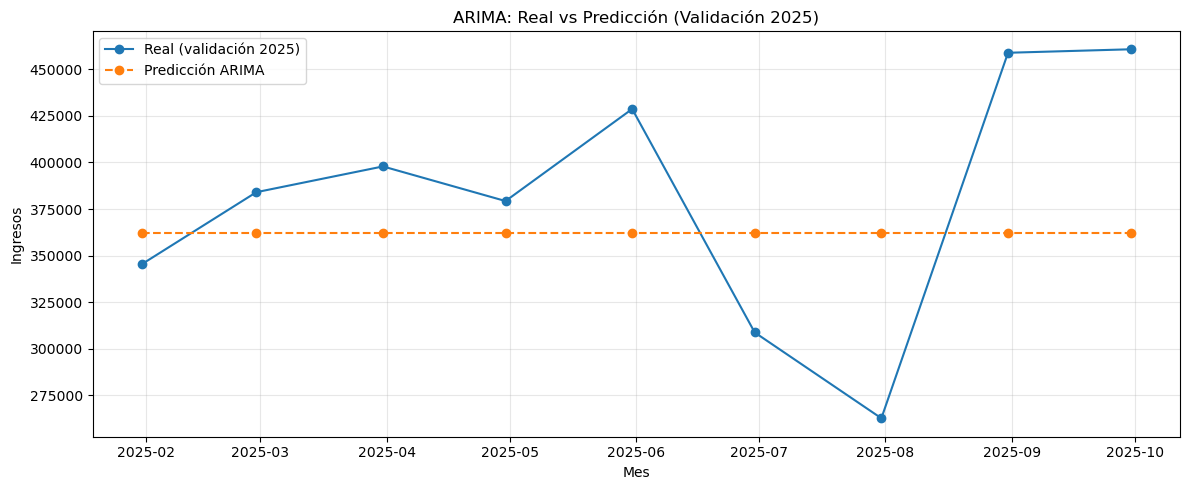

MAE  : 56,258.64
MAPE : 15.25%


In [39]:
# predecir, graficar y calcular MAE/MAPE Arima
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# generar predicción alineada
pred_arima_valid = safe_predict_pmdarima(model_arima, len(valid), index=valid.index)
if pred_arima_valid is None:
    raise RuntimeError("No se pudo generar la predicción. Reentrena model_arima o carga el modelo desde disco.")

# gráfico
plt.figure(figsize=(12,5))
plt.plot(valid.index, valid, marker='o', label='Real (validación 2025)')
plt.plot(pred_arima_valid.index, pred_arima_valid, marker='o', linestyle='--', label='Predicción ARIMA')
plt.title('ARIMA: Real vs Predicción (Validación 2025)')
plt.xlabel('Mes')
plt.ylabel('Ingresos')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# métricas
def mape_safe(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    mask = (y_true != 0) & (~np.isnan(y_true)) & (~np.isnan(y_pred))
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mae_arima = mean_absolute_error(valid, pred_arima_valid)
mape_arima = mape_safe(valid, pred_arima_valid)

print(f"MAE  : {mae_arima:,.2f}")
print(f"MAPE : {mape_arima:.2f}%")


In [40]:
def mape(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [41]:
# ===== Entrenamiento modelo SARIMA =====
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
import pandas as pd
import time
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error

# ------- Función MAPE -------
def mape(y_true, y_pred):
    y_true = np.array(y_true).astype(float)
    y_pred = np.array(y_pred).astype(float)
    mask = ~np.isnan(y_true) & (y_true != 0) & ~np.isnan(y_pred)
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Parámetros del grid (rango controlado)
p_values = [0,1,2]
q_values = [0,1,2]
P_values = [0,1]
Q_values = [0,1]
d = 1
D = 1
m = 12

# Comprobar que train_clean y valid existen
try:
    _ = train_clean
    _ = valid
except NameError:
    raise NameError("Define primero train_clean y valid.")

# Transformación log (evitar ceros)
eps = 1e-6
train_t = np.log(train_clean + 1 + eps)

best_mae = np.inf
best_mape = np.inf
best_cfg = None
best_res = None
best_pred = None
results_list = []

start_all = time.time()
total_models = len(p_values)*len(q_values)*len(P_values)*len(Q_values)
print(f"Probando {total_models} modelos SARIMA...")

count = 0
for p,q,P,Q in itertools.product(p_values, q_values, P_values, Q_values):
    count += 1
    order = (p,d,q)
    seasonal_order = (P,D,Q,m)
    try:
        t0 = time.time()
        model = SARIMAX(train_t, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=50)  # limitar iteraciones para velocidad
        fit_time = time.time() - t0

        # Forecast en espacio transformado
        steps = len(valid)
        fc_t = res.get_forecast(steps=steps).predicted_mean
        # Invertir log
        fc = np.exp(fc_t) - 1

        # Alinear indices
        try:
            fc = pd.Series(fc, index=valid.index)
        except Exception:
            fc = pd.Series(fc)

        # Calcular MAE y MAPE
        common_idx = valid.index.intersection(fc.index)
        y_true = valid.loc[common_idx].astype(float)
        y_pred = fc.loc[common_idx].astype(float)
        mask = (~y_true.isna()) & (~y_pred.isna())
        if mask.sum() == 0:
            print(f"[{count}/{total_models}] order={order} seasonal={seasonal_order} -> sin datos comunes, se omite.")
            continue

        mae = mean_absolute_error(y_true[mask], y_pred[mask])
        mape_val = mape(y_true[mask], y_pred[mask])

        results_list.append((order, seasonal_order, mae, mape_val, fit_time))
        # Guardar mejor según MAE
        if mae < best_mae:
            best_mae = mae
            best_mape = mape_val
            best_cfg = (order, seasonal_order)
            best_res = res
            best_pred = fc

        print(f"[{count}/{total_models}] order={order} seasonal={seasonal_order} MAE={mae:.2f}  MAPE={mape_val:.2f}%  time={fit_time:.2f}s")

    except Exception as e:
        # ignora fallos pero registra (mostrar parte del error)
        print(f"[{count}/{total_models}] order={(p,d,q)} seasonal={(P,D,Q,m)} -> FAIL: {str(e)[:120]}")

end_all = time.time()
print(f"\nGrid completo en {end_all - start_all:.1f}s.")
print(f"Mejor MAE = {best_mae:.2f}, MAPE (mejor por MAE) = {best_mape:.2f}% para {best_cfg}")

Probando 36 modelos SARIMA...
[1/36] order=(0, 1, 0) seasonal=(0, 1, 0, 12) MAE=18318.83  MAPE=5.32%  time=0.03s
[2/36] order=(0, 1, 0) seasonal=(0, 1, 1, 12) MAE=98041.83  MAPE=26.22%  time=0.09s
[3/36] order=(0, 1, 0) seasonal=(1, 1, 0, 12) MAE=178704.29  MAPE=47.61%  time=0.04s
[4/36] order=(0, 1, 0) seasonal=(1, 1, 1, 12) MAE=179260.76  MAPE=47.80%  time=0.12s
[5/36] order=(0, 1, 1) seasonal=(0, 1, 0, 12) MAE=20328.36  MAPE=5.88%  time=0.03s
[6/36] order=(0, 1, 1) seasonal=(0, 1, 1, 12) MAE=104362.49  MAPE=27.88%  time=0.19s
[7/36] order=(0, 1, 1) seasonal=(1, 1, 0, 12) MAE=128876.32  MAPE=34.52%  time=0.09s
[8/36] order=(0, 1, 1) seasonal=(1, 1, 1, 12) MAE=16451.39  MAPE=4.62%  time=0.19s
[9/36] order=(0, 1, 2) seasonal=(0, 1, 0, 12) MAE=22424.36  MAPE=6.47%  time=0.05s
[10/36] order=(0, 1, 2) seasonal=(0, 1, 1, 12) MAE=16802.94  MAPE=4.75%  time=0.26s
[11/36] order=(0, 1, 2) seasonal=(1, 1, 0, 12) MAE=85497.94  MAPE=23.09%  time=0.24s
[12/36] order=(0, 1, 2) seasonal=(1, 1, 1, 12

In [42]:
# ===== Cargar el modelo SARIMA  =====

from statsmodels.tsa.statespace.sarimax import SARIMAXResults

ruta_modelo = "modelos/mejor_sarima.pkl"

modelo_cargado = SARIMAXResults.load(ruta_modelo)

print("Modelo cargado correctamente:")
print(modelo_cargado.summary())


Modelo cargado correctamente:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  17.872
Date:                             Fri, 21 Nov 2025   AIC                            -25.743
Time:                                     14:30:19   BIC                            -20.765
Sample:                                 01-31-2022   HQIC                           -24.771
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6389      0.761      0.840      0.401      -0.852       2.1

Mejor configuración encontrada: ((2, 1, 2), (0, 1, 0, 12))
MAE en validación (mejor modelo): 13949.557040327229
MAPE en validación (mejor modelo): 4.00%


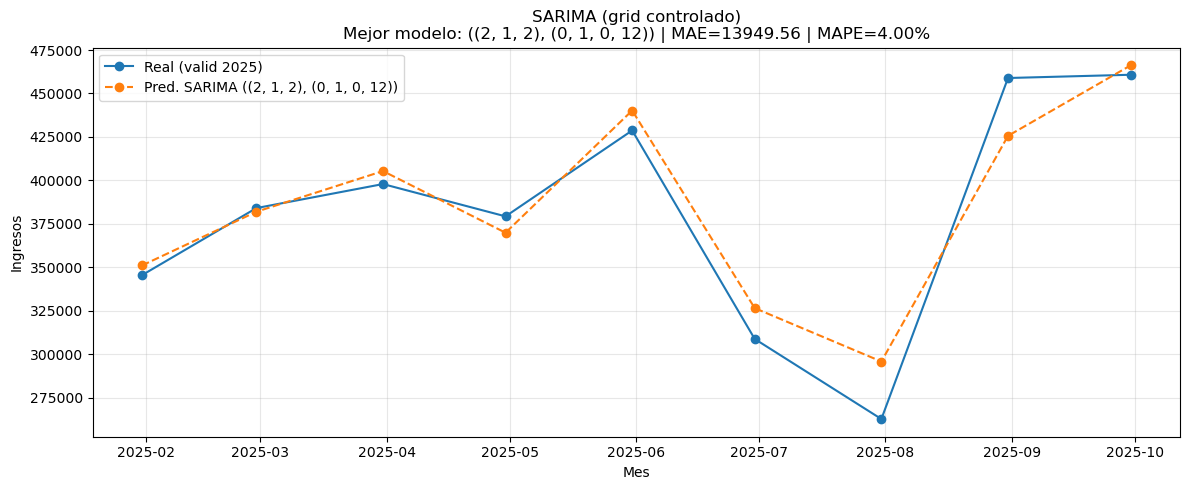


Tabla comparativa Real vs Predicho:


,Real,Predicho,Error_abs,MAPE_%,RMSE_component
2025-01-31,345443.17,351027.986550,5584.816550,1.616711,3.119018e+07
2025-02-28,384053.63,381945.904792,2107.725208,0.548810,4.442506e+06
2025-03-31,397886.77,405361.190767,7474.420767,1.878530,5.586697e+07
2025-04-30,379295.45,369887.810089,9407.639911,2.480293,8.850369e+07
2025-05-31,428729.83,440204.509580,11474.679580,2.676436,1.316683e+08
2025-06-30,308738.62,326484.212037,17745.592037,5.747772,3.149060e+08
2025-07-31,262667.08,295764.750527,33097.670527,12.600616,1.095456e+09
2025-08-31,458908.25,425629.542415,33278.707585,7.251713,1.107472e+09
2025-09-30,460782.03,466156.791198,5374.761198,1.166443,2.888806e+07



===== MÉTRICAS FINALES (validación ene–sep 2025) =====
MAE  : 13,949.56
MAPE : 4.00%
RMSE : 17,821.32


In [43]:
# predecir, graficar y calcular MAE/MAPE Sarima__
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from IPython.display import display

# Comprobar que el entrenamiento produjo un mejor modelo
try:
    best_res
except NameError:
    raise NameError("No existe 'best_res'. Ejecuta primero la Celda 1 (entrenamiento).")

if best_res is None:
    print("No se encontró un modelo válido en el grid. Revisa la Celda 1.")
else:
    print("Mejor configuración encontrada:", best_cfg)
    print("MAE en validación (mejor modelo):", best_mae)
    print("MAPE en validación (mejor modelo):", f"{best_mape:.2f}%")

    # Predicción en validación (calculada en Celda 1)
    pred_best = best_pred.copy()

    # Gráfico comparativo: Real vs Predicción (validación)
    plt.figure(figsize=(12,5))
    plt.plot(valid.index, valid, marker='o', label='Real (valid 2025)')
    plt.plot(pred_best.index, pred_best, marker='o', linestyle='--', label=f'Pred. SARIMA {best_cfg}')
    
    plt.title(
        f"SARIMA (grid controlado)\n"
        f"Mejor modelo: {best_cfg} | MAE={best_mae:.2f} | MAPE={best_mape:.2f}%"
    )
    plt.xlabel('Mes')
    plt.ylabel('Ingresos')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Tabla comparativa Real vs Predicho
    comp = pd.DataFrame({'Real': valid, 'Predicho': pred_best})
    comp['Error_abs'] = (comp['Real'] - comp['Predicho']).abs()
    comp['MAPE_%'] = (comp['Error_abs'] / comp['Real']) * 100
    comp['RMSE_component'] = (comp['Real'] - comp['Predicho'])**2  # para inspección

    print("\nTabla comparativa Real vs Predicho:")
    display(comp)

    # Métricas finales
    rmse = np.sqrt(comp['RMSE_component'].mean())

    print("\n===== MÉTRICAS FINALES (validación ene–sep 2025) =====")
    print(f"MAE  : {best_mae:,.2f}")
    print(f"MAPE : {best_mape:.2f}%")
    print(f"RMSE : {rmse:,.2f}")


In [44]:
# ===== Guardar el mejor modelo SARIMA =====

import os

# Crear carpeta de modelos si no existe
os.makedirs("modelos", exist_ok=True)

ruta_modelo = "modelos/mejor_sarima.pkl"
ruta_config = "modelos/mejor_sarima_config.txt"

# Guardar modelo statsmodels
best_res.save(ruta_modelo)

# Guardar config en un archivo de texto
with open(ruta_config, "w") as f:
    f.write(f"best_cfg = {best_cfg}\n")
    f.write(f"best_mae = {best_mae}\n")

print("Modelo guardado correctamente en:")
print(" -", ruta_modelo)
print(" -", ruta_config)


Modelo guardado correctamente en:
 - modelos/mejor_sarima.pkl
 - modelos/mejor_sarima_config.txt


In [45]:
# ===== Cargar el modelo SARIMA previamente guardado =====

from statsmodels.tsa.statespace.sarimax import SARIMAXResults

ruta_modelo = "modelos/mejor_sarima.pkl"

modelo_cargado = SARIMAXResults.load(ruta_modelo)

print("Modelo cargado correctamente:")
print(modelo_cargado.summary())


Modelo cargado correctamente:
                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                   36
Model:             SARIMAX(2, 1, 2)x(0, 1, [], 12)   Log Likelihood                  17.872
Date:                             Fri, 21 Nov 2025   AIC                            -25.743
Time:                                     14:30:25   BIC                            -20.765
Sample:                                 01-31-2022   HQIC                           -24.771
                                      - 12-31-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6389      0.761      0.840      0.401      -0.852       2.1

modelo_cargado ya en memoria.

Probando métodos sobre el modelo cargado...
Metodo get_forecast: longitud=3, NaNs=0

Predicciones OCT-DIC 2025 (valores finales):


2025-10-31    351027.986550
2025-11-30    381945.904792
2025-12-31    405361.190767
Freq: ME, dtype: float64


Ingresos reales ene–sep 2025: 3,426,504.83
Predicción oct–dic 2025 (suma): 1,138,335.08
Total proyectado 2025: 4,564,839.91


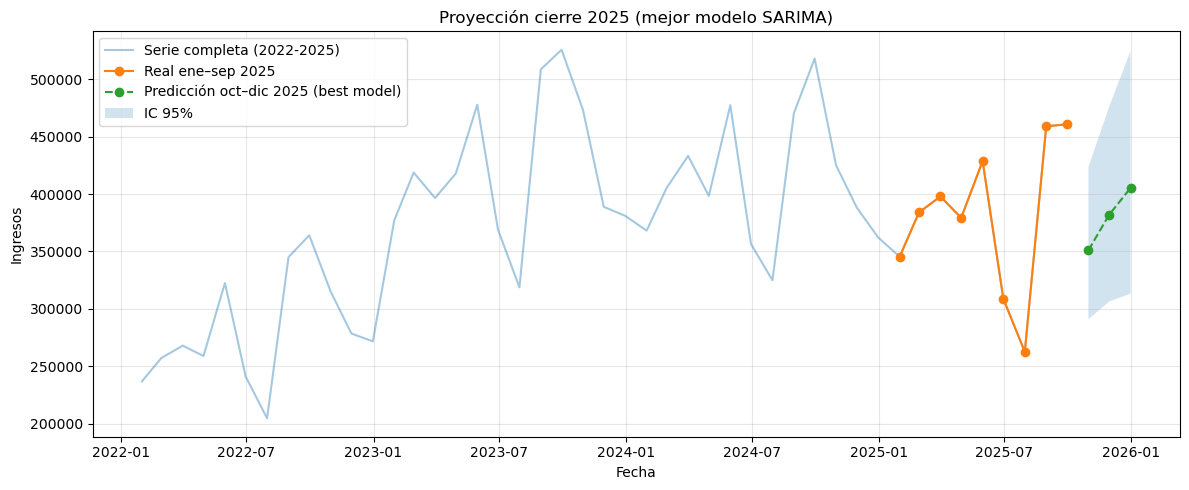


Predicción guardada en: prediccion_oct_dic_2025_mejor_sarima.csv


In [46]:
# ===== Usar modelo guardado para predecir OCT-DIC 2025 (carga, diagnóstico y refit si hace falta) =====
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAXResults, SARIMAX
import warnings
warnings.filterwarnings("ignore")

# rutas
ruta_modelo = "modelos/mejor_sarima.pkl"
ruta_config = "modelos/mejor_sarima_config.txt"

# periodo a predecir
steps = 3
future_idx = pd.date_range(start="2025-10-01", periods=steps, freq='M')

# cargar modelo si no existe en memoria
try:
    modelo_cargado
    print("modelo_cargado ya en memoria.")
except NameError:
    if not os.path.exists(ruta_modelo):
        raise FileNotFoundError(f"No se encontró el archivo del modelo en: {ruta_modelo}")
    modelo_cargado = SARIMAXResults.load(ruta_modelo)
    print("Modelo cargado desde disco.")

# intentar métodos directamente sobre el objeto cargado
def try_methods(res, steps):
    out = {}
    try:
        gf = res.get_forecast(steps=steps)
        out['get_forecast'] = gf.predicted_mean
        out['get_forecast_ci'] = gf.conf_int() if hasattr(gf, 'conf_int') else None
    except Exception as e:
        out['get_forecast'] = ("ERROR", str(e))
        out['get_forecast_ci'] = None
    try:
        fc = res.forecast(steps=steps)
        out['forecast'] = fc
    except Exception as e:
        out['forecast'] = ("ERROR", str(e))
    try:
        start = int(getattr(res, 'nobs', 0))
        pr = res.predict(start=start, end=start+steps-1)
        out['predict'] = pr
    except Exception as e:
        out['predict'] = ("ERROR", str(e))
    return out

print("\nProbando métodos sobre el modelo cargado...")
methods_out = try_methods(modelo_cargado, steps)

# inspeccionar y elegir la primera predicción válida (sin NaN)
chosen_pred_t = None
chosen_ci_t = None
for k in ['get_forecast','forecast','predict']:
    v = methods_out.get(k)
    if v is None:
        continue
    if isinstance(v, tuple) and v[0] == "ERROR":
        print(f"Metodo {k} -> ERROR: {v[1][:180]}")
        continue
    try:
        s = pd.Series(v)
        # si viene sin índice, le ponemos future_idx si longitudes coinciden
        if len(s) == steps and not isinstance(s.index, pd.DatetimeIndex):
            s.index = future_idx
        # convertir a numeric y comprobar NaNs
        s_num = pd.to_numeric(s, errors='coerce')
        nans = s_num.isna().sum()
        print(f"Metodo {k}: longitud={len(s_num)}, NaNs={nans}")
        if nans == 0:
            chosen_pred_t = s_num
            # si existe intervalo de conf (solo para get_forecast)
            if k == 'get_forecast' and methods_out.get('get_forecast_ci') is not None:
                ci = methods_out['get_forecast_ci']
                # ci puede devolver DataFrame con same index
                try:
                    if len(ci) == steps:
                        chosen_ci_t = ci
                        if not isinstance(chosen_ci_t.index, pd.DatetimeIndex):
                            chosen_ci_t.index = future_idx
                except Exception:
                    chosen_ci_t = None
            break
    except Exception as e:
        print(f"Error evaluando metodo {k}: {e}")

# Si no encontramos predicción válida -> re-ajustar mejor modelo sobre toda la información (2022-01..2025-09)
if chosen_pred_t is None:
    print("\nNo se obtuvo predicción válida directamente. Reajustando el mejor modelo sobre la serie completa hasta 2025-09...")
    # Cargar configuración desde archivo si existe
    try:
        with open(ruta_config, 'r') as f:
            cfg_txt = f.read()
        print("Configuración encontrada en:", ruta_config)
        print(cfg_txt)
    except Exception:
        print("No se encontró/leyó el archivo de config. Usaremos best_cfg si existe en el entorno.")
    # intentar obtener best_cfg del notebook (si existe)
    try:
        order, seasonal_order = best_cfg
        print("Usando best_cfg desde memoria:", best_cfg)
    except Exception:
        # intentar parsear el config file buscando 'best_cfg' si está presente
        try:
            import ast
            with open(ruta_config, 'r') as f:
                txt = f.read()
            if 'best_cfg' in txt:
                # crude parse: eval line that has best_cfg
                for line in txt.splitlines():
                    if 'best_cfg' in line:
                        rhs = line.split('=',1)[1].strip()
                        best_cfg = ast.literal_eval(rhs)
                        order, seasonal_order = best_cfg
                        print("Parsed best_cfg from file:", best_cfg)
                        break
        except Exception:
            order = None
            seasonal_order = None
            print("No se pudo determinar best_cfg. Abortar reajuste.")
    if order is None or seasonal_order is None:
        raise RuntimeError("No disponemos de la configuración (order, seasonal_order). Coloca best_cfg en el namespace o el archivo de config.")
    # preparar serie completa hasta 2025-09 y transformar (log) como en entrenamiento
    eps = 1e-6
    full_series = serie['2022-01-31':'2025-09-30'].astype(float)
    full_t = np.log(full_series + 1 + eps)
    print("Reajustando SARIMAX con order", order, "seasonal_order", seasonal_order)
    try:
        refit = SARIMAX(full_t, order=order, seasonal_order=seasonal_order,
                        enforce_stationarity=False, enforce_invertibility=False).fit(disp=False, maxiter=200)
        print("Refit OK. Ahora vamos a predecir.")
        gf = refit.get_forecast(steps=steps)
        pred_t = gf.predicted_mean
        ci_t = None
        try:
            ci_t = gf.conf_int()
            if len(ci_t) == steps:
                ci_t.index = future_idx
        except Exception:
            ci_t = None
        pred_t = pd.Series(pred_t)
        if len(pred_t) == steps and not isinstance(pred_t.index, pd.DatetimeIndex):
            pred_t.index = future_idx
        pred_t = pd.to_numeric(pred_t, errors='coerce')
        print("NaNs en predicción transformada (refit):", pred_t.isna().sum())
        if pred_t.isna().sum() == 0:
            chosen_pred_t = pred_t
            chosen_ci_t = ci_t
            # opcional: guardar refit en variable modelo_cargado (reemplaza)
            modelo_cargado = refit
        else:
            print("Resultado del refit contiene NaNs. Revisar ajustes.")
    except Exception as e:
        raise RuntimeError(f"Error al refit del modelo sobre la serie completa: {e}")

# A este punto, chosen_pred_t debería existir (valores en espacio transformado)
if chosen_pred_t is None:
    raise RuntimeError("No se pudo obtener predicciones válidas ni después de refit. Revisa el modelo/configuración.")

# Invertir la transformacion log -> espacio original
pred_original = np.exp(chosen_pred_t) - 1
pred_series = pd.Series(pred_original.values, index=future_idx)

# si hay CI transformados, invertirlos también (aproximación exp)
ci_lower, ci_upper = None, None
if chosen_ci_t is not None:
    try:
        # chosen_ci_t columns might be like ['lower y', 'upper y'] — convert to numeric and exp-1
        ci_vals = chosen_ci_t.astype(float)
        ci_lower = np.exp(ci_vals.iloc[:,0]) - 1
        ci_upper = np.exp(ci_vals.iloc[:,1]) - 1
        ci_lower = pd.Series(ci_lower.values, index=future_idx)
        ci_upper = pd.Series(ci_upper.values, index=future_idx)
    except Exception:
        ci_lower = ci_upper = None

# Mostrar resultados
print("\nPredicciones OCT-DIC 2025 (valores finales):")
display(pred_series)

real_ene_sep = serie['2025-01-31':'2025-09-30'].sum()
pred_sum = pred_series.sum()
total_proj = real_ene_sep + pred_sum

print(f"\nIngresos reales ene–sep 2025: {real_ene_sep:,.2f}")
print(f"Predicción oct–dic 2025 (suma): {pred_sum:,.2f}")
print(f"Total proyectado 2025: {total_proj:,.2f}")

# Gráfico final con CI si existe
plt.figure(figsize=(12,5))
plt.plot(serie, label='Serie completa (2022-2025)', alpha=0.4)
plt.plot(serie['2025-01-31':'2025-09-30'].index, serie['2025-01-31':'2025-09-30'], marker='o', label='Real ene–sep 2025')
plt.plot(pred_series.index, pred_series, marker='o', linestyle='--', label='Predicción oct–dic 2025 (best model)')
if ci_lower is not None and ci_upper is not None:
    plt.fill_between(ci_lower.index, ci_lower.values, ci_upper.values, alpha=0.2, label='IC 95%')
plt.title("Proyección cierre 2025 (mejor modelo SARIMA)")
plt.xlabel("Fecha")
plt.ylabel("Ingresos")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Guardar predicción como CSV
out_df = pd.DataFrame({'pred_oct_dic_2025': pred_series})
out_df.to_csv("prediccion_oct_dic_2025_mejor_sarima.csv", index=True)
print("\nPredicción guardada en: prediccion_oct_dic_2025_mejor_sarima.csv")


In [47]:
# ===== Tabla con intervalos de confianza (IC 95%) para oct–dic 2025 =====
import numpy as np
import pandas as pd

steps = 3
future_idx = pd.date_range(start="2025-10-01", periods=steps, freq='M')

# obtener predicción transformada con intervalo de confianza
gf = modelo_cargado.get_forecast(steps=steps)
pred_t = gf.predicted_mean
ci_t = gf.conf_int()  # intervalo en escala transformada (log)

# invertir log -> escala original
pred = np.exp(pred_t) - 1
lower = np.exp(ci_t.iloc[:,0]) - 1
upper = np.exp(ci_t.iloc[:,1]) - 1

# asegurar índices correctos
pred.index = future_idx
lower.index = future_idx
upper.index = future_idx

# construir tabla
tabla_ic = pd.DataFrame({
    "Predicción": pred,
    "IC_95%_inferior": lower,
    "IC_95%_superior": upper
})

print("Tabla de predicciones con intervalos de confianza (IC 95%):")
display(tabla_ic)

Tabla de predicciones con intervalos de confianza (IC 95%):


,Predicción,IC_95%_inferior,IC_95%_superior
2025-10-31,351027.986550,290996.904888,423443.111894
2025-11-30,381945.904792,306508.809517,475949.307464
2025-12-31,405361.190767,313223.292542,524602.326167


Configuración extraída desde objeto cargado:
  order = (2, 1, 2)
  seasonal_order = (0, 1, 0, 12)

Reajustando modelo con order (2, 1, 2) seasonal_order (0, 1, 0, 12) sobre toda la serie disponible...
Refit completado.

Predicción 2026 (con IC 95%):


,pred_2026,ci_lower,ci_upper
2026-01-31,385041.033095,324791.670701,456466.711940
2026-02-28,347757.522103,286615.482476,421942.597418
2026-03-31,323352.565191,259099.117025,403540.030094
2026-04-30,306911.893620,240659.753018,391402.762719
2026-05-31,339794.978535,261357.927232,441771.960470
2026-06-30,350611.551144,265162.776406,463596.112268
2026-07-31,332967.129064,248048.226174,446957.761704
2026-08-31,375021.882619,275613.803680,510284.226374
2026-09-30,269155.942851,195395.320755,370760.637705
2026-10-31,228267.155131,163869.820598,317971.110330



Total proyectado 2026: 4,054,625.89 Bs
Guardado en: prediccion_2026_mejor_sarima_con_IC.csv


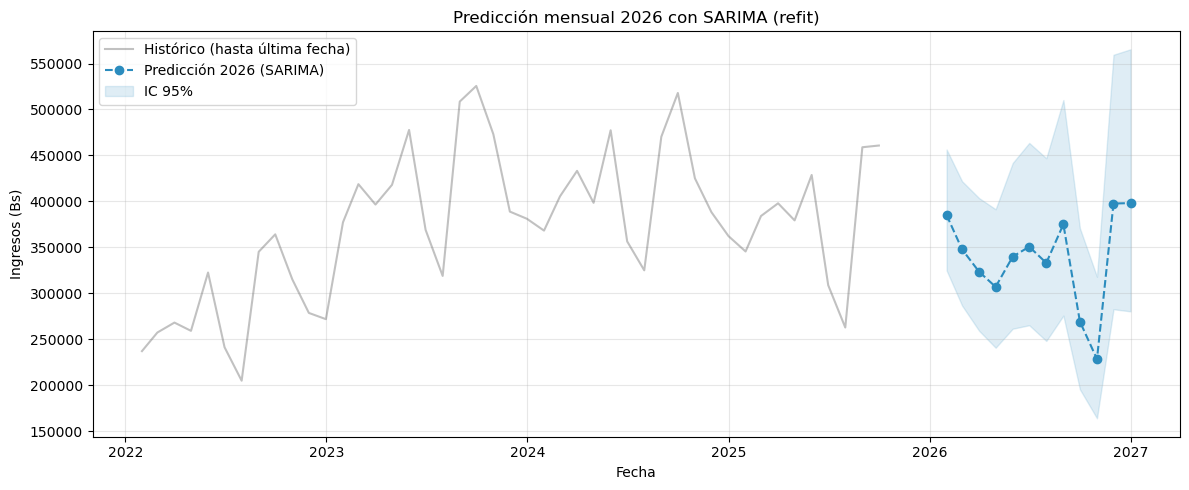

In [48]:
# Cargar config de forma segura, refit y predecir 2026 con IC
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX, SARIMAXResults

ruta_modelo = "modelos/mejor_sarima.pkl"
ruta_cfg = "modelos/mejor_sarima_config.txt"

# 1) cargar modelo (si no está en memoria)
try:
    modelo_cargado
except NameError:
    modelo_cargado = SARIMAXResults.load(ruta_modelo)

# 2) Extraer order y seasonal_order preferentemente desde el objeto cargado
order = None
seasonal_order = None

# statsmodels internals: modelo_cargado.model.order / .seasonal_order
try:
    order = modelo_cargado.model.order
    seasonal_order = modelo_cargado.model.seasonal_order
    print("Configuración extraída desde objeto cargado:")
    print("  order =", order)
    print("  seasonal_order =", seasonal_order)
except Exception as e:
    print("No se pudo extraer order desde el objeto:", e)

# 3) Si no se pudo, intentar parsear el archivo .txt de forma tolerante
if (order is None or seasonal_order is None) and os.path.exists(ruta_cfg):
    try:
        txt = open(ruta_cfg).read()
        # buscar algo que parezca (p,d,q)
        m1 = re.search(r"\(?\s*\(?\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\)?\s*\)?", txt)
        tuples = re.findall(r"\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\)", txt)
        if tuples:
            # tomar el primer como order y el segundo como seasonal si hay dos
            order = eval(tuples[0])
            if len(tuples) > 1:
                seasonal_order = eval(tuples[1])
            else:
                # intentar buscar cuatro elementos (P,D,Q,m)
                m2 = re.search(r"\(\s*\d+\s*,\s*\d+\s*,\s*\d+\s*,\s*\d+\s*\)", txt)
                if m2:
                    seasonal_order = eval(m2.group(0))
    except Exception as e:
        print("Falló parseo tolerante del .txt:", e)

# 4) Si aún no hay config, abortar con mensaje claro
if order is None or seasonal_order is None:
    raise RuntimeError("No se pudo determinar order/seasonal_order. Coloca 'best_cfg' en el namespace o revisa modelos/mejor_sarima_config.txt")

# 5) Preparar serie y transform (log)
eps = 1e-6
try:
    serie_full = serie.copy()  # usar la serie que ya tienes
except NameError:
    raise RuntimeError("No encuentro la variable 'serie' en memoria. Carga la serie primero.")

serie_log = np.log(serie_full + 1 + eps)

# 6) Reajustar modelo con todos los datos disponibles (refit)
print("\nReajustando modelo con order", order, "seasonal_order", seasonal_order, "sobre toda la serie disponible...")
model_refit = SARIMAX(serie_log, order=order, seasonal_order=seasonal_order,
                      enforce_stationarity=False, enforce_invertibility=False)
res_refit = model_refit.fit(disp=False, maxiter=200)
print("Refit completado.")

# 7) Forecast 12 meses 2026 con IC
steps = 12
fc_obj = res_refit.get_forecast(steps=steps)
fc_log = fc_obj.predicted_mean
ci_log = fc_obj.conf_int(alpha=0.05)

# Invertir log
fc = np.exp(fc_log) - 1
ci_lower = np.exp(ci_log.iloc[:,0]) - 1
ci_upper = np.exp(ci_log.iloc[:,1]) - 1

# Índice para 2026
idx_2026 = pd.date_range(start="2026-01-31", periods=steps, freq="M")
fc = pd.Series(fc.values, index=idx_2026, name="pred_2026")
ci_lower = pd.Series(ci_lower.values, index=idx_2026, name="ci_lower")
ci_upper = pd.Series(ci_upper.values, index=idx_2026, name="ci_upper")

# 8) Mostrar tabla y totales
df_fc = pd.concat([fc, ci_lower, ci_upper], axis=1)
print("\nPredicción 2026 (con IC 95%):")
display(df_fc)

total_2026 = fc.sum()
print(f"\nTotal proyectado 2026: {total_2026:,.2f} Bs")

# 9) Guardar CSV
out_csv = "prediccion_2026_mejor_sarima_con_IC.csv"
df_fc.to_csv(out_csv)
print("Guardado en:", out_csv)

# 10) Gráfico con banda IC
plt.figure(figsize=(12,5))
plt.plot(serie_full, label="Histórico (hasta última fecha)", color="#666666", alpha=0.4)
plt.plot(fc.index, fc.values, marker='o', linestyle='--', label="Predicción 2026 (SARIMA)", color="#2b8cbe")
plt.fill_between(fc.index, ci_lower.values, ci_upper.values, color="#2b8cbe", alpha=0.15, label="IC 95%")
plt.title("Predicción mensual 2026 con SARIMA (refit)")
plt.ylabel("Ingresos (Bs)")
plt.xlabel("Fecha")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


GRAFICOS PARA EL ANALISIS DE LOS DATOS

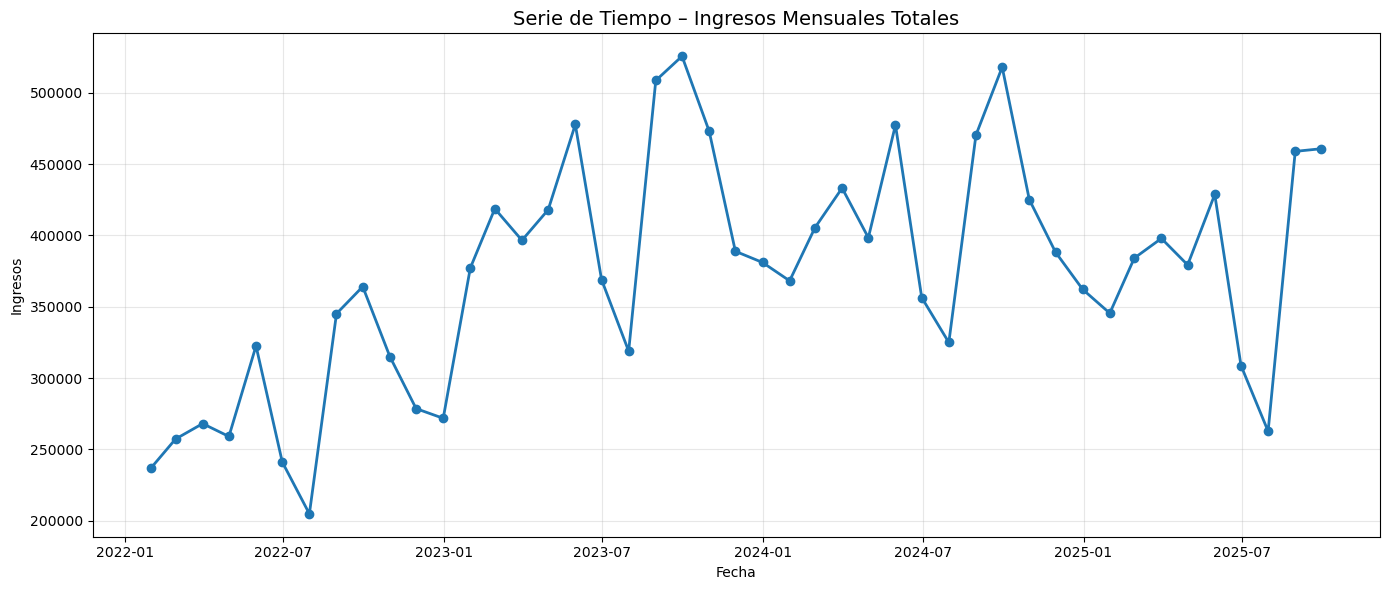

In [49]:
# ============================================================
# GRAFICO 1 – Serie de tiempo original (usando `serie` existente)
# ============================================================

import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(serie.index, serie.values, marker="o", linewidth=2)
plt.title("Serie de Tiempo – Ingresos Mensuales Totales", fontsize=14)
plt.xlabel("Fecha")
plt.ylabel("Ingresos")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


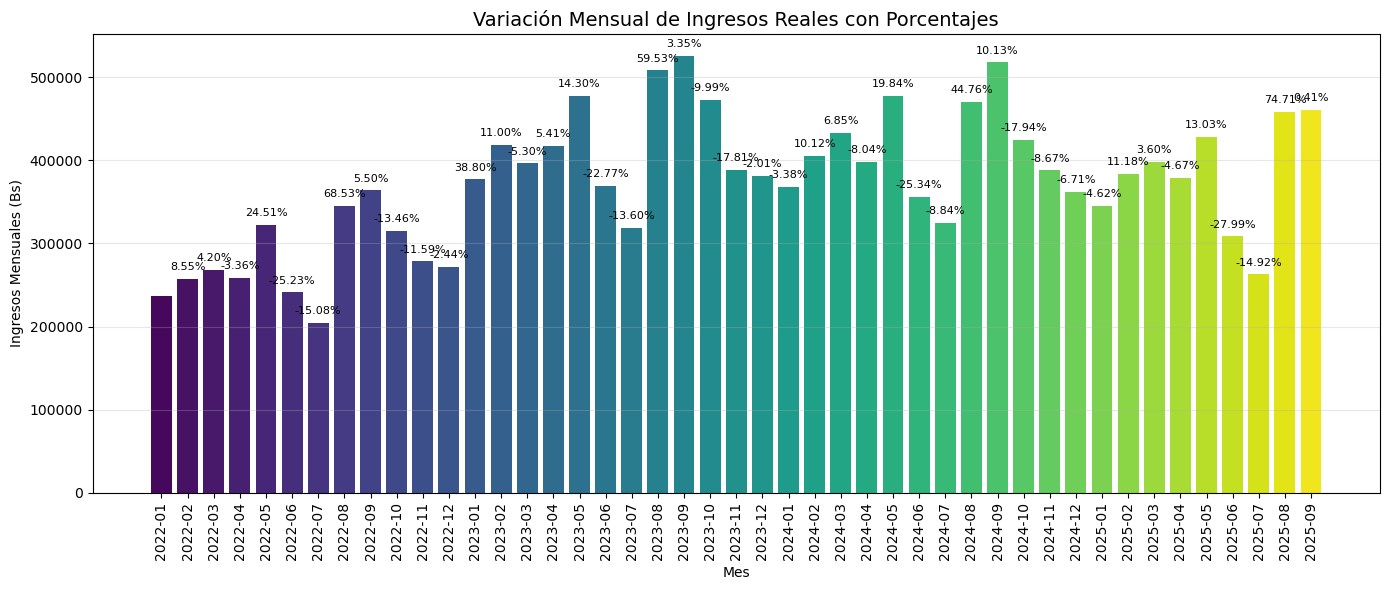

In [50]:
# ============================================================
# GRAFICO – Variación mensual de ingresos con porcentajes
# ============================================================

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Copiar la serie real ---
df_var = serie.copy().to_frame(name="Ingresos")
df_var.index = pd.to_datetime(df_var.index)

# Variación porcentual mes a mes
df_var['Variacion_%'] = df_var['Ingresos'].pct_change() * 100

# --- Gráfico tipo barras con gradiente de color ---
plt.figure(figsize=(14,6))
colors = sns.color_palette("viridis", len(df_var))

bars = plt.bar(
    df_var.index.strftime("%Y-%m"),
    df_var['Ingresos'],
    color=colors
)

# --- Etiquetas de porcentaje encima de cada barra ---
for i, val in enumerate(df_var['Variacion_%']):
    if not np.isnan(val):
        plt.text(
            i,
            df_var['Ingresos'].iloc[i] + df_var['Ingresos'].max() * 0.02,
            f"{val:.2f}%",
            ha='center',
            fontsize=8
        )

# --- Configuración estética ---
plt.title('Variación Mensual de Ingresos Reales con Porcentajes', fontsize=14)
plt.xlabel('Mes')
plt.ylabel('Ingresos Mensuales (Bs)')
plt.xticks(rotation=90)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


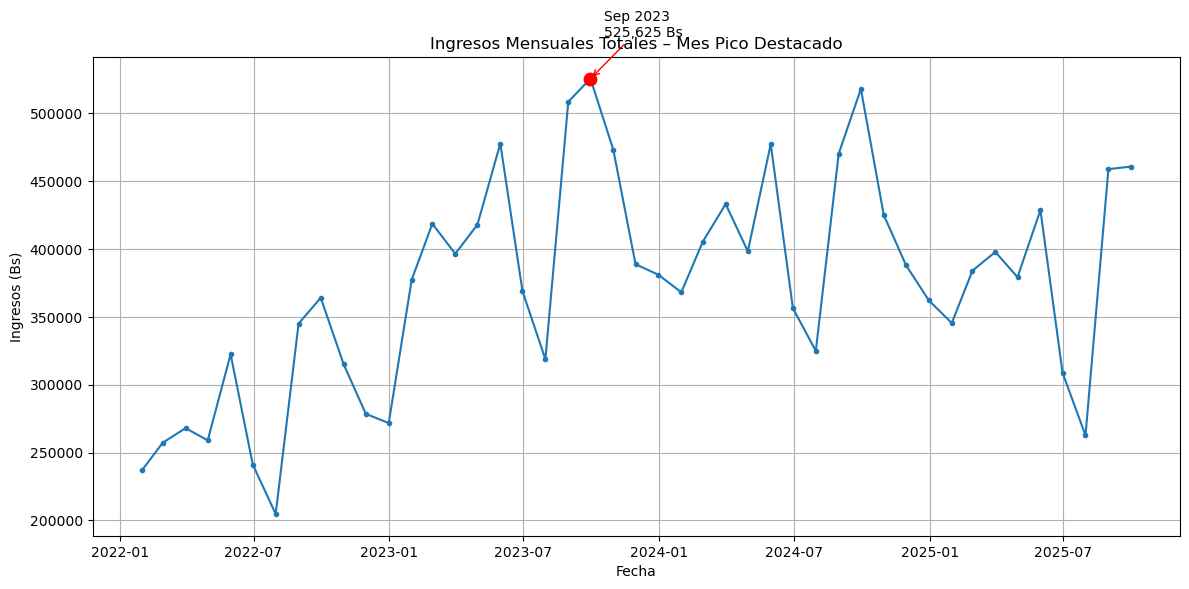

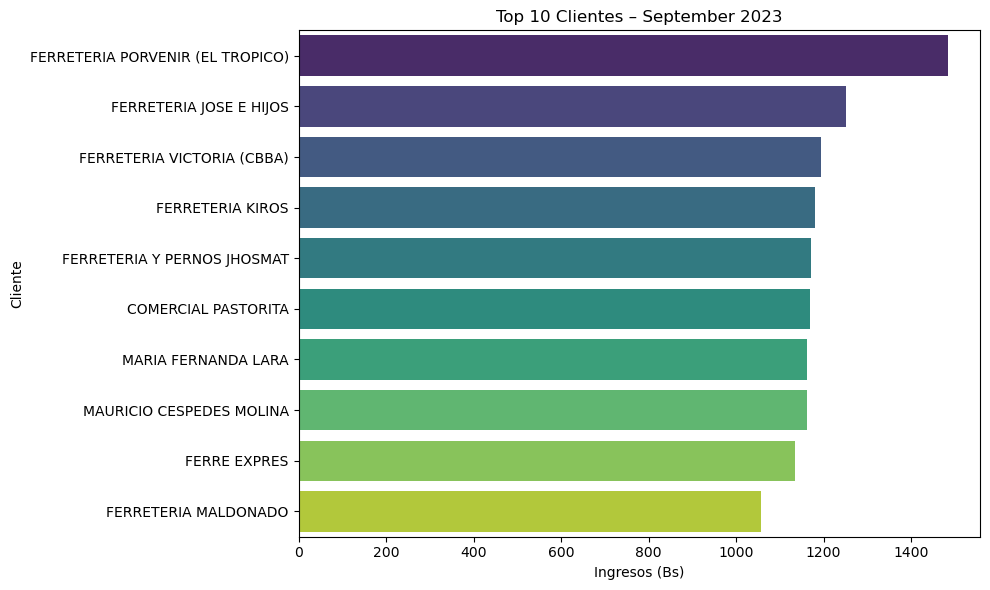

,Ingresos_mes_pico
Nombre Comercial o Nombre del Cliente,
FERRETERIA PORVENIR (EL TROPICO),1483.30
FERRETERIA JOSE E HIJOS,1251.25
FERRETERIA VICTORIA (CBBA),1193.27
FERRETERIA KIROS,1181.11
FERRETERIA Y PERNOS JHOSMAT,1171.22
COMERCIAL PASTORITA,1168.72
MARIA FERNANDA LARA,1161.66
MAURICIO CESPEDES MOLINA,1161.21
FERRE EXPRES,1133.52


In [51]:
# ================================================================
# TOP 10 CLIENTES DEL MES PICO + GRAFICOS (versión limpia)
# ================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- seleccionar el dataframe correcto ---
dfc = data.copy()
dfc.columns = dfc.columns.astype(str).str.replace('\n',' ', regex=False).str.strip()

# --- serie y mes pico ---
ts = serie.copy().to_frame(name="Ingresos")
ts.index = pd.to_datetime(ts.index)

idx_pico = ts['Ingresos'].idxmax()
valor_pico = float(ts['Ingresos'].max())

# --- columna del mes pico ---
mes_map = {
    1:'ene',2:'feb',3:'mar',4:'abr',5:'may',6:'jun',
    7:'jul',8:'ago',9:'sep',10:'oct',11:'nov',12:'dic'
}
col_estandar = f"{mes_map[idx_pico.month]}-{str(idx_pico.year)[-2:]}"

dfc[col_estandar] = pd.to_numeric(dfc[col_estandar], errors='coerce').fillna(0)

# --- factor de escala ---
suma_raw = dfc[col_estandar].sum()
ratio = valor_pico / suma_raw if suma_raw != 0 else 1
factor = ratio if (4 < ratio < 20) else (1000 if 800 < ratio < 1200 else 1)

dfc_adj = dfc.copy()
dfc_adj[col_estandar] = dfc_adj[col_estandar] * factor

# --- localizar columna cliente ---
cliente_candidates = [c for c in dfc_adj.columns if 'nombre' in c.lower() and 'cliente' in c.lower()]
if len(cliente_candidates) == 0:
    cliente_candidates = [c for c in dfc_adj.columns if 'nombre' in c.lower()]
col_cliente = cliente_candidates[0]

# --- top10 clientes ---
ing_cli = dfc_adj.groupby(col_cliente)[col_estandar].sum().sort_values(ascending=False)
top10 = ing_cli.head(10)

# ================================================================
# GRAFICO 1: Serie con mes pico marcado
# ================================================================
plt.figure(figsize=(12,6))
plt.plot(ts['Ingresos'], marker='.')
plt.scatter([idx_pico], [valor_pico], color='red', s=80, zorder=5)
plt.annotate(
    f"{idx_pico.strftime('%b %Y')}\n{valor_pico:,.0f} Bs",
    xy=(idx_pico, valor_pico),
    xytext=(10, 30),
    textcoords='offset points',
    arrowprops=dict(arrowstyle='->', color='red')
)
plt.title('Ingresos Mensuales Totales – Mes Pico Destacado')
plt.xlabel('Fecha')
plt.ylabel('Ingresos (Bs)')
plt.grid(True)
plt.tight_layout()
plt.show()

# ================================================================
# GRAFICO 2: Top 10 clientes del mes pico
# ================================================================
plt.figure(figsize=(10,6))
sns.barplot(x=top10.values, y=top10.index, palette='viridis')
plt.title(f"Top 10 Clientes – {idx_pico.strftime('%B %Y')}")
plt.xlabel('Ingresos (Bs)')
plt.ylabel('Cliente')
plt.tight_layout()
plt.show()

# --- mostrar tabla top10 ---
top10.to_frame(name="Ingresos_mes_pico")


In [52]:
import pandas as pd

# ============================
# 1. Copia del DataFrame base
# ============================
df = data.copy()
df.columns = df.columns.astype(str).str.replace('\n',' ', regex=False).str.strip()

# ============================
# 2. Detectar columna de cliente
# ============================
col_cliente_candidates = [c for c in df.columns 
                          if 'nombre' in c.lower() and 'cliente' in c.lower()]

if len(col_cliente_candidates) == 0:
    # plan B: buscar solo 'nombre'
    col_cliente_candidates = [c for c in df.columns if 'nombre' in c.lower()]

col_cliente = col_cliente_candidates[0]

# ============================
# 3. Detectar columnas de meses (ene-22 ... sep-25)
# ============================
meses_validos = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']

cols_meses = [
    c for c in df.columns 
    if '-' in c and c[:3].lower() in meses_validos
]

# Convertir a numérico
for c in cols_meses:
    df[c] = pd.to_numeric(df[c], errors='coerce').fillna(0)

# ============================
# 4. Total 2022–2025 por cliente
# ============================
df['Total_2022_2025'] = df[cols_meses].sum(axis=1)

ingresos_clientes = (
    df.groupby(col_cliente)['Total_2022_2025']
      .sum()
      .sort_values(ascending=False)
)

top15 = ingresos_clientes.head(15).reset_index()

# ============================
# 5. Mostrar resultado final
# ============================
display(top15)


,Nombre Comercial o Nombre del Cliente,Total_2022_2025
0,FERRETERIA AMBAR,31858.66
1,FERRETERIA UNION,31324.10
2,FERRETERIA R Y C (ORURO),29355.79
3,COMERCIAL VICTORIA,26281.64
4,DISTRIBUIDORA VIRGEN DEL ROSARIO,25786.72
5,FERRETERIA CRISS ELECTRIC,25507.85
6,FERRETERIA PORVENIR (EL TROPICO),25504.96
7,FERRETERIA EL CONSTRUCTOR (JAIMES FREYRE),25163.31
8,COMERCIAL YENNY,25136.33
9,FERRETERIA VICTORIA (CBBA),24954.14


In [53]:
import pandas as pd

# ============================
# 1. Copiar y limpiar nombres
# ============================
df = data.copy()
df.columns = df.columns.astype(str).str.replace('\n', ' ', regex=False).str.strip()

# ============================
# 2. Detectar columna de cliente
# ============================
cliente_cols = [c for c in df.columns if "nombre" in c.lower() and "cliente" in c.lower()]
if len(cliente_cols) == 0:
    cliente_cols = [c for c in df.columns if "nombre" in c.lower()]  # fallback

col_cliente = cliente_cols[0]

# ============================
# 3. Detectar columnas de meses
# ============================
meses_validos = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
cols_meses = [
    c for c in df.columns 
    if '-' in c and c[:3].lower() in meses_validos
]

# Convertir a numérico
df[cols_meses] = df[cols_meses].apply(pd.to_numeric, errors='coerce').fillna(0)

# ============================
# 4. Calcular meses con venta
# ============================
df['Meses_con_venta'] = (df[cols_meses] > 0).sum(axis=1)
total_meses = len(cols_meses)

# ============================
# 5. Clasificar clientes
# ============================
def clasificar_cliente(meses):
    if meses >= total_meses * 0.75:
        return "Constante"
    elif meses >= total_meses * 0.25:
        return "Intermitente"
    else:
        return "No constante"

df['Tipo_cliente'] = df['Meses_con_venta'].apply(clasificar_cliente)

# ============================
# 6. Conteo y porcentajes
# ============================
conteo = df['Tipo_cliente'].value_counts()
total_clientes = len(df)

constantes = conteo.get("Constante", 0)
intermitentes = conteo.get("Intermitente", 0)
no_constantes = conteo.get("No constante", 0)

# ============================
# 7. Mostrar resultados
# ============================
print(f"Clientes constantes     : {constantes}  ({constantes/total_clientes*100:.2f}%)")
print(f"Clientes intermitentes  : {intermitentes}  ({intermitentes/total_clientes*100:.2f}%)")
print(f"Clientes no constantes  : {no_constantes}  ({no_constantes/total_clientes*100:.2f}%)")


Clientes constantes     : 1751  (73.76%)
Clientes intermitentes  : 623  (26.24%)
Clientes no constantes  : 0  (0.00%)


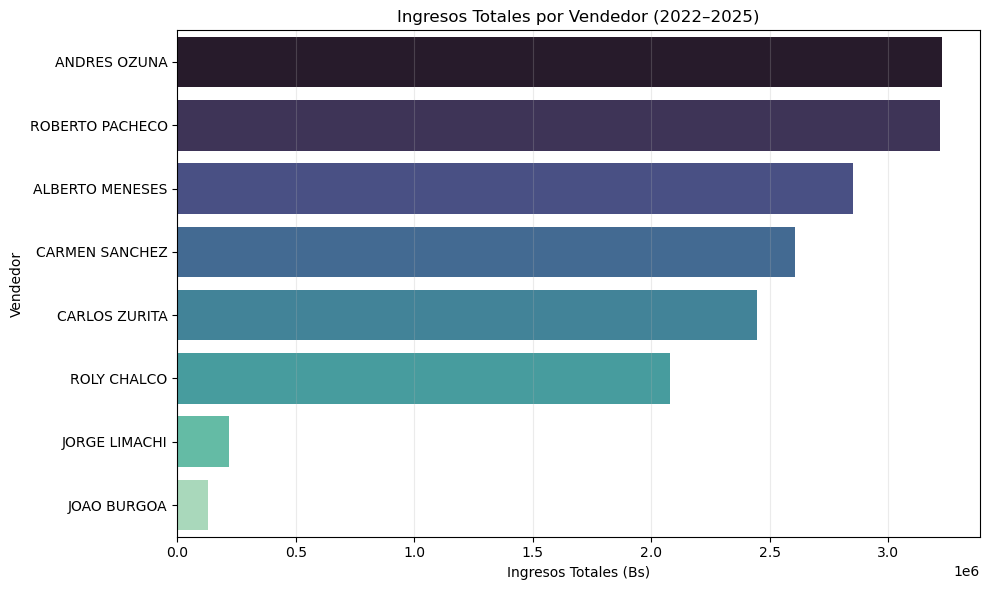

,Total_2022_2025,Participacion_%
Vendedor,,
ANDRES OZUNA,3224826.24,19.23
ROBERTO PACHECO,3216098.21,19.18
ALBERTO MENESES,2852424.13,17.01
CARMEN SANCHEZ,2607653.03,15.55
CARLOS ZURITA,2445446.16,14.58
ROLY CHALCO,2079061.77,12.40
JORGE LIMACHI,218098.50,1.30
JOAO BURGOA,128103.13,0.76


In [54]:
# ============================================================
# Ingresos totales y participación por Vendedor (2022-2025)
# Celda robusta: detecta df_crudo/data/raw y columna vendedor
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 0) Seleccionar DF base (df_crudo, data o raw)
if 'df_crudo' in globals():
    df_base = df_crudo.copy()
elif 'data' in globals():
    df_base = data.copy()
elif 'raw' in globals():
    df_base = raw.copy()
else:
    raise NameError("No se encontró df_crudo, data ni raw en el workspace.")

# 1) Normalizar nombres columnas
df_base.columns = df_base.columns.astype(str).str.replace('\n', ' ', regex=False).str.strip()

# 2) Detectar columna vendedor
vendedor_candidates = [c for c in df_base.columns if 'vendedor' in c.lower()]
if len(vendedor_candidates) == 0:
    # buscar alternativas (mayor probabilidad)
    vendedor_candidates = [c for c in df_base.columns if 'vend' in c.lower() or 'seller' in c.lower()]
if len(vendedor_candidates) == 0:
    raise KeyError("No se encontró columna de vendedor. Revisa los nombres de columnas.")
# preferir exact match 'Vendedor'
col_vendedor = next((c for c in vendedor_candidates if c.lower() == 'vendedor'), vendedor_candidates[0])
# asegurar string y strip
df_base[col_vendedor] = df_base[col_vendedor].astype(str).str.strip()

# 3) Detectar columnas de meses (ene-22 ... sep-25)
meses_validos = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
cols_meses = [c for c in df_base.columns if '-' in c and str(c)[:3].lower() in meses_validos]

# ordenar columnas de meses por año y mes
def sort_key(col):
    try:
        mon = str(col)[:3].lower()
        yy = int('20' + str(col).split('-')[1])
        m = meses_validos.index(mon) + 1
        return (yy, m)
    except Exception:
        return (9999, 99)

cols_meses = sorted(cols_meses, key=sort_key)

# 4) Convertir a numérico y rellenar NaN con 0
if len(cols_meses) == 0:
    raise KeyError("No se detectaron columnas de meses con formato 'mes-aa' (ej. ene-22). Revisa las columnas.")
df_base[cols_meses] = df_base[cols_meses].apply(pd.to_numeric, errors='coerce').fillna(0)

# 5) Totales por fila y por vendedor (2022-2025)
df_base['Total_2022_2025'] = df_base[cols_meses].sum(axis=1)
vendedores_tot = df_base.groupby(col_vendedor)['Total_2022_2025'].sum().sort_values(ascending=False)

# 6) Participación %
total_general = vendedores_tot.sum()
participacion = (vendedores_tot / total_general * 100).round(2)

# 7) Gráfico: barras horizontales por vendedor
plt.figure(figsize=(10, max(6, len(vendedores_tot)*0.15)))
sns.barplot(x=vendedores_tot.values, y=vendedores_tot.index, palette='mako')
plt.title('Ingresos Totales por Vendedor (2022–2025)')
plt.xlabel('Ingresos Totales (Bs)')
plt.ylabel('Vendedor')
plt.grid(axis='x', alpha=0.25)
plt.tight_layout()
plt.show()

# 8) Tabla resumen (Total + Participación)
resumen = pd.DataFrame({
    'Total_2022_2025': vendedores_tot,
    'Participacion_%': participacion
})
resumen['Total_2022_2025'] = resumen['Total_2022_2025'].round(2)

display(resumen)


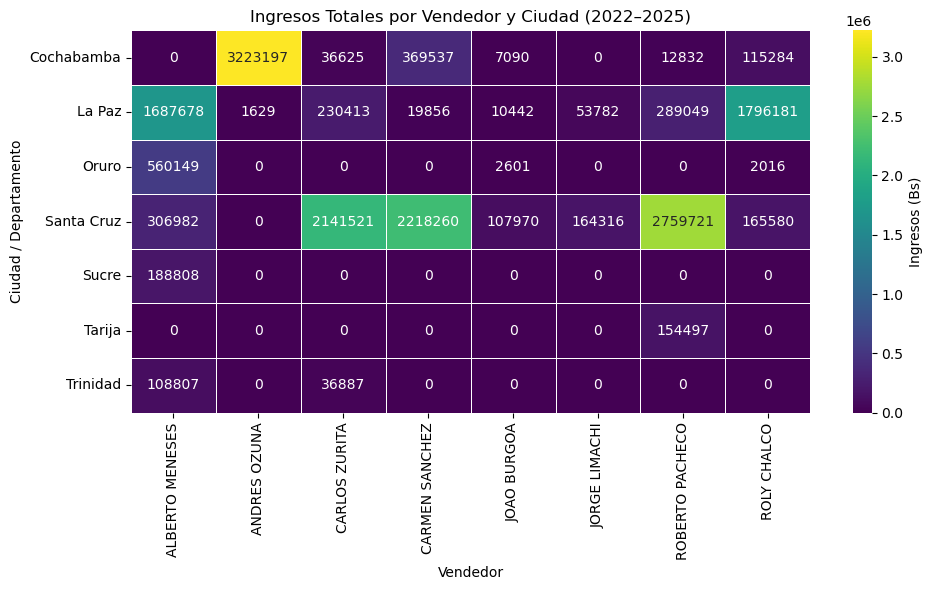

In [55]:
# ============================================================
# Heatmap: Ingresos acumulados (2022-2025) por Ciudad (fila) y Vendedor (columna)
# Celda robusta: detecta df_crudo / data / raw y nombres de columnas
# ============================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 0) elegir dataframe base
if 'df_crudo' in globals():
    df = df_crudo.copy()
elif 'data' in globals():
    df = data.copy()
elif 'raw' in globals():
    df = raw.copy()
else:
    raise NameError("No se encontró df_crudo, data ni raw en el workspace.")

# 1) normalizar nombres
df.columns = df.columns.astype(str).str.replace('\n', ' ', regex=False).str.strip()

# 2) detectar columna vendedor y ciudad
v_candidates = [c for c in df.columns if 'vendedor' in c.lower()]
if not v_candidates:
    v_candidates = [c for c in df.columns if 'vend' in c.lower() or 'seller' in c.lower()]
if not v_candidates:
    raise KeyError("No se encontró columna de 'vendedor'. Revisa columnas.")
col_vendedor = next((c for c in v_candidates if c.lower() == 'vendedor'), v_candidates[0])

ciudad_candidates = [c for c in df.columns if 'ciudad' in c.lower() or 'depart' in c.lower()]
if not ciudad_candidates:
    # fallback: buscar 'zona' o 'region'
    ciudad_candidates = [c for c in df.columns if 'zona' in c.lower() or 'region' in c.lower()]
if not ciudad_candidates:
    raise KeyError("No se encontró columna de 'ciudad'/'departamento' en el DataFrame.")
col_ciudad = ciudad_candidates[0]

# 3) detectar columnas de meses (ene-22 ... sep-25)
meses_validos = ['ene','feb','mar','abr','may','jun','jul','ago','sep','oct','nov','dic']
cols_meses = [c for c in df.columns if '-' in str(c) and str(c)[:3].lower() in meses_validos]
if len(cols_meses) == 0:
    raise KeyError("No se detectaron columnas de meses con formato 'mes-aa' (ej. ene-22). Revisa las columnas.")

# ordenar columnas de meses cronológicamente
def sort_key(col):
    try:
        mon = str(col)[:3].lower()
        yy = int('20' + str(col).split('-')[1])
        m = meses_validos.index(mon) + 1
        return (yy, m)
    except:
        return (9999, 99)
cols_meses = sorted(cols_meses, key=sort_key)

# 4) asegurar numérico
df[cols_meses] = df[cols_meses].apply(pd.to_numeric, errors='coerce').fillna(0)

# 5) total acumulado 2022-2025 por fila
df['Total_2022_2025'] = df[cols_meses].sum(axis=1)

# 6) agrupar por ciudad y vendedor
ingresos_geo = df.groupby([col_ciudad, col_vendedor])['Total_2022_2025'].sum().reset_index()

# 7) pivot para heatmap
pivot = ingresos_geo.pivot_table(index=col_ciudad, columns=col_vendedor, values='Total_2022_2025', fill_value=0)

# si la matriz es muy grande, limitar vendedores top N para mejor lectura
max_cols_display = 30
if pivot.shape[1] > max_cols_display:
    top_vendors = ingresos_geo.groupby(col_vendedor)['Total_2022_2025'].sum().nlargest(max_cols_display).index
    pivot = pivot[top_vendors]

# 8) plot
plt.figure(figsize=(max(10, pivot.shape[1]*0.6), max(6, pivot.shape[0]*0.4)))
cmap = 'viridis'
sns.heatmap(pivot, cmap=cmap, annot=(pivot.size <= 300), fmt='.0f', linewidths=0.4, cbar_kws={'label': 'Ingresos (Bs)'})
plt.title('Ingresos Totales por Vendedor y Ciudad (2022–2025)')
plt.xlabel('Vendedor')
plt.ylabel('Ciudad / Departamento')
plt.tight_layout()
plt.show()
